# Twitter Sentiment Analysis - POC
---

## 7. Quickly train various models

**Current State**: I've trained three baseline models without much tweaking on BoW matrices and using cross validation got the following accuracy scores:

- Logistic Regression: $78.8\%$
- Naive Bayes: $77.6\%$ 
- SGD (log loss): $77.1\%$ 

**Next Steps**: Train Single Decision Trees.


In [1]:
import re
import os
import time
import json

import numpy as np
import pandas as pd
import scipy.sparse as sp

from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### Load $m\approx250k$, $n=50k$ training subset

In [2]:
# time notebook
start_notebook = time.time()

# processed dir
proc_dir = os.path.join("..","data","3_processed","sentiment140")
X_train_transformed = sp.load_npz(os.path.join(proc_dir, "X_train_transformed_BoW_250k_50k.npz"))
with open(os.path.join(proc_dir, "y_array_250k.npy"), 'rb') as f:
    y_array = np.load(f)

In [3]:
# sanity check
X_train_transformed, len(y_array)

(<251468x50001 sparse matrix of type '<class 'numpy.int32'>'
 	with 2569112 stored elements in Compressed Sparse Row format>,
 251468)

### Decision Trees


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_train_transformed, 
                                                    y_array, 
                                                    test_size=0.25, 
                                                    random_state=2)

In [5]:
clf = DecisionTreeClassifier(criterion="gini", max_depth=5, random_state=42)

In [6]:
start_time = time.time()
clf.fit(X_train, y_train)
mins, secs = divmod(time.time() - start_time, 60)
print(f'Time: {mins:0.0f} mins and {secs:0.0f} secs')

Time: 0 mins and 14 secs


In [7]:
y_pred = clf.predict(X_test)

In [8]:
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))

Accuracy: 0.632


In [9]:
# Cross validate with entire 250k rows
scores = cross_val_score(clf, X_train_transformed, y_array, cv=5, verbose=3, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................... , score=0.631, total=   5.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s remaining:    0.0s


[CV] .................................... , score=0.633, total=   7.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.1s remaining:    0.0s


[CV] .................................... , score=0.632, total=   8.6s
[CV]  ................................................................
[CV] .................................... , score=0.632, total=   9.1s
[CV]  ................................................................
[CV] .................................... , score=0.629, total=   8.9s
Accuracy: 0.63 (+/- 0.00)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   38.8s finished


### GridSearch

This is just a tiny grid search for decision trees with a few different values for max depth.

In [10]:
start_time = time.time()

depth, runtime, accuracy = [], [], []
for i in range(10, 290, 40):
    clf = DecisionTreeClassifier(criterion="gini", max_depth=i, random_state=42)
    depth.append(i)
    
    start_gridsearch = time.time()
    clf.fit(X_train, y_train)
    runtime.append(round(time.time() - start_time, 1))
    
    y_pred = clf.predict(X_test)
    accuracy.append(round(accuracy_score(y_test, y_pred), 4))
    
mins, secs = divmod(time.time() - start_gridsearch, 60)
print(f'Gridsearch total time: {mins:0.0f} mins and {secs:0.0f} secs')

Gridsearch total time: 5 mins and 60 secs


In [11]:
df = pd.DataFrame(
    {'depth': depth,
     'runtime': runtime,
     'accuracy': accuracy
    })
df

,depth,runtime,accuracy
0,10,18.1,0.6545
1,50,137.0,0.7018
2,90,336.8,0.7128
3,130,585.8,0.7158
4,170,862.5,0.7150
5,210,1204.3,0.7160
6,250,1564.0,0.7144


In [12]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def plot_learning_curves_feed_m(model, X, y, Xname):
    """Plot the learning curves for train and validation sets
       , by adding more rows (m) and keeping the number of 
       features (n) constant.
       Args:
           model: a classifier
           X: sparce matrix of features
           y: target vector
           Xname: vectorization method
       Evaluates accuracy (TODO: implement other metrics)
    """
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                          test_size=0.2, 
                                                          random_state=42)
    # train
    # change data granularity (denominator) for more/less data points
    data_granularity = int(X_train.shape[0]/8)
    xs, train_acc, valid_acc = [], [], []
    for m in range(10, X_train.shape[0], data_granularity):       
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_valid_predict = model.predict(X_valid)
        train_acc.append(accuracy_score(y_train[:m], y_train_predict))
        valid_acc.append(accuracy_score(y_valid, y_valid_predict))
        xs.append(str(m-1))

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_axes([0.0, 
                       # dynamically calculate number of x ticks
                       round(X_train.shape[0]/data_granularity, 0), 
                       0.4, 0.8])
    plt.plot(xs, np.sqrt(train_acc), 'r--', linewidth=.8, 
             label="train accuracy")
    plt.plot(xs, np.sqrt(valid_acc), 'b--', linewidth=.8, 
             label="validation accuracy")
    plt.xticks(rotation=45)
    plt.title(''.join(["Learning Rates for Training and Validation - ", 
                       Xname]), 
              fontsize=16)
    plt.legend(loc="lower right", fontsize=14)
    plt.xlabel("Training Set Size", fontsize=14)
    plt.ylabel("Accuracy", fontsize=14)
    plt.show()

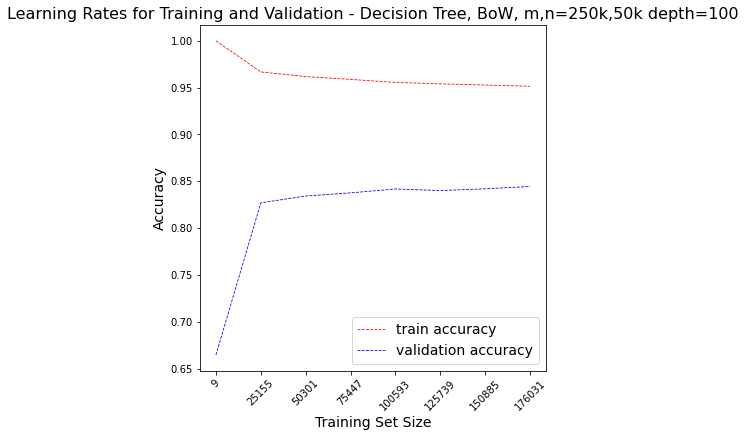

In [13]:
tree_clf = DecisionTreeClassifier(criterion="gini", max_depth=100, random_state=42)

plot_learning_curves_feed_m(tree_clf, X_train_transformed, y_array, 
                           'Decision Tree, BoW, m,n=250k,50k depth=100')

The model is overfitting the train set quite a lot, given the huge gap. A ton of data might help but the validation accuracy isn't necessarily increasing a lot.

Another parameter we might consider tweaking a bit is `max_features`, since default is **None**, or `n_features`.

[(source)](https://github.com/scikit-learn/scikit-learn/blob/0fb307bf3/sklearn/tree/_classes.py#L597)

```
class sklearn.tree.DecisionTreeClassifier(*, criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, presort='deprecated', ccp_alpha=0.0

    max_features : int, float or {"auto", "sqrt", "log2"}, default=None
        The number of features to consider when looking for the best split:
            - If int, then consider `max_features` features at each split.
            - If float, then `max_features` is a fraction and
              `int(max_features * n_features)` features are considered at each
              split.
            - If "auto", then `max_features=sqrt(n_features)`.
            - If "sqrt", then `max_features=sqrt(n_features)`.
            - If "log2", then `max_features=log2(n_features)`.
            - If None, then `max_features=n_features`.

```

In [14]:
# Cross validate with max features 1000
tree_clf = DecisionTreeClassifier(criterion="gini", max_depth=100, random_state=42, max_features=1000)

scores = cross_val_score(tree_clf, X_train_transformed, y_array, cv=5, verbose=3, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.697, total=  30.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.5s remaining:    0.0s


[CV] .................................... , score=0.701, total=  33.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


[CV] .................................... , score=0.687, total=  35.0s
[CV]  ................................................................
[CV] .................................... , score=0.693, total=  34.3s
[CV]  ................................................................
[CV] .................................... , score=0.696, total=  34.4s
Accuracy: 0.69 (+/- 0.01)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.8min finished


In [15]:
# Cross validate deep trees
tree_clf = DecisionTreeClassifier(criterion="gini", max_depth=1000, random_state=42)

scores = cross_val_score(tree_clf, X_train_transformed, y_array, cv=5, verbose=3, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................... , score=0.715, total= 7.6min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.6min remaining:    0.0s


[CV] .................................... , score=0.714, total= 6.7min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 14.4min remaining:    0.0s


[CV] .................................... , score=0.715, total= 7.4min
[CV]  ................................................................
[CV] .................................... , score=0.717, total= 7.7min
[CV]  ................................................................
[CV] .................................... , score=0.712, total= 7.2min
Accuracy: 0.71 (+/- 0.00)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 36.7min finished


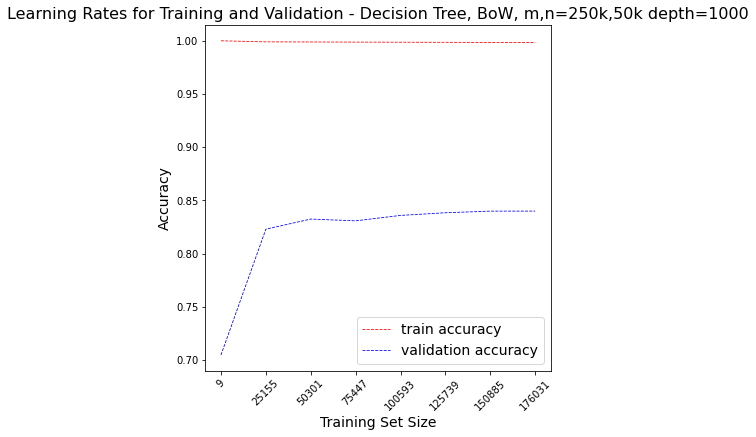

In [16]:
tree_clf = DecisionTreeClassifier(criterion="gini", max_depth=1000, max_features=5000, random_state=42)

plot_learning_curves_feed_m(tree_clf, X_train_transformed, y_array,
                           'Decision Tree, BoW, m,n=250k,50k depth=1000')

This tree appears to not be learning. 

In [17]:
# time notebook
mins, secs = divmod(time.time() - start_notebook, 60)
print(f'Total running time: {mins:0.0f} minute(s) and {secs:0.0f} second(s).')

Total running time: 83 minute(s) and 53 second(s).


---